In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Магия для того, чтобы notebook автоматически подгружал изменения кода в файлах на диске
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import os.path
import tqdm
VIDTIMIT_PATH = '../data/vidtimit/'

from nn.speaker import Dataset
from torchvision import transforms
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(0.5,0.5,0.5,0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])
    ])

train_set = Dataset(VIDTIMIT_PATH, transform, exclude=['fadg0'])
print("Loaded classes:", train_set.c)

valid_set = Dataset(VIDTIMIT_PATH, transform, include=['fadg0'])
print("Loaded classes:", valid_set.c)
img = valid_set[0][0]

#dl = torch.utils.data.DataLoader(dataset=train_set, batch_size=8, shuffle=False)
# for i, (images, labels) in enumerate(mn_dataset_loader):
#     if i == 5: break
#     # Feed the data to the model
#     print(images[0].shape, labels[0])

100810it [00:00, 316618.45it/s]
2732it [00:00, 331563.61it/s]

Loaded classes: {0: 56387, 1: 44423}
Loaded classes: {0: 1494, 1: 1238}


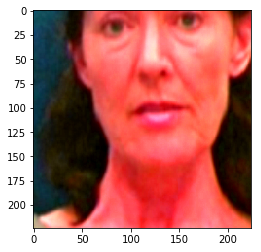

In [4]:
plt.imshow(img.permute(1,2,0))

In [8]:
import os
os.environ['TORCH_MODEL_ZOO'] = '../data/'
from torchvision.models import resnet18
resnet = resnet18(pretrained=True)

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import Module
import torch.nn

#model = torch.nn.DataParallel(model).cuda()
from nn.speaker import get_speaking_detector, Net
from nn.trainer import Trainer
class MyTrainer(Trainer):
    def save(self, epoch):
        torch.save(self.net, '../data/speaker/model.e{}.pt'.format(epoch))
        
    def get_options(self, epoch):
        loss = CrossEntropyLoss()
        trainable = filter(lambda p: p.requires_grad, self.net.parameters())
        if epoch<12:
            opt = Adam(trainable, lr=0.005, weight_decay=5e-4)
        elif epoch<18:
            opt = Adam(trainable, lr=0.001, weight_decay=2e-4)
        elif epoch<24:
            opt = Adam(trainable, lr=0.00031, weight_decay=5e-5)
        return loss, opt
    
    def get_data(self):
        dl = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=4)
        for i, (images, labels) in enumerate(dl):
            #print(len(images), images[0].shape, len(labels), labels)
            yield (images.cuda(), labels.cuda())

#net = Net()
#net.cuda();


In [9]:
net = get_speaking_detector(16)
t = MyTrainer(net, N_seconds=10, seed=random.randrange(1<<31), start=17)
t.train_net(25, 1000)

[17,     1] loss: 0.091
[17,    45] loss: 0.182
[17,    85] loss: 0.182
[17,   125] loss: 0.160
[17,   161] loss: 0.181
[17,   197] loss: 0.196
[17,   229] loss: 0.179
[17,   257] loss: 0.170
[17,   285] loss: 0.170
[17,   313] loss: 0.163
[17,   341] loss: 0.175
[17,   369] loss: 0.187
[17,   393] loss: 0.164
[17,   416] loss: 0.179
[17,   437] loss: 0.176
[17,   461] loss: 0.175
[17,   501] loss: 0.167
[17,   539] loss: 0.183
[17,   577] loss: 0.182
[17,   617] loss: 0.184
[17,   657] loss: 0.180
[17,   697] loss: 0.169
[17,   734] loss: 0.172
[17,   771] loss: 0.169
[17,   809] loss: 0.164
[17,   846] loss: 0.186
[17,   884] loss: 0.167
[17,   921] loss: 0.185
[17,   961] loss: 0.172
[17,  1000] loss: 0.162
[18,     1] loss: 0.156
[18,    41] loss: 0.168
[18,    81] loss: 0.194
[18,   121] loss: 0.176
[18,   161] loss: 0.160
[18,   198] loss: 0.161
[18,   238] loss: 0.168
[18,   278] loss: 0.178
[18,   315] loss: 0.181
[18,   354] loss: 0.167
[18,   396] loss: 0.172
[18,   438] loss

UnboundLocalError: local variable 'opt' referenced before assignment

In [ ]:
losses = t.get_losses()
plt.plot(losses[50:]); # random guessing loss is 0.69
#plt.yscale('log');
plt.show();